In [1]:
import pandas as pd # import traditional libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression # The first model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve # for model evaluation

# Imbalanced Learn for handling imbalance
from imblearn.over_sampling import SMOTE

# Supress warnings for clear output
import warnings
warnings.filterwarnings('ignore')

print("--- Starting Data Loading and Full Preprocessing Pipeline ---")

# Import Data
data_path = 'data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018q4.csv'
df_accepted = pd.read_csv(data_path, low_memory=False)
print("Raw Data Loaded.")

# Target Mapping
target_mapping = {
    "Charged Off": 1,
    "Default": 1,
    "Late (31-120 days)": 1,
    "Does not meet the credit policy. Status:Charged Off": 1,
    "Fully Paid": 0,
    "Does not meet the credit policy. Status:Fully Paid": 0
} 

final_statuses_for_model = list(target_mapping.keys())
df_filtered = df_accepted[df_accepted['loan_status'].isin(final_statuses_for_model)].copy()
df_filtered['is_default'] = df_filtered['loan_status'].map(target_mapping)
y = df_filtered['is_default']
print("Target variable 'is_default' defined and data filtered.")

--- Starting Data Loading and Full Preprocessing Pipeline ---
Raw Data Loaded.
Target variable 'is_default' defined and data filtered.


In [2]:
columns_to_drop = [
    # 1. Identifiers and Unnecessary Columns
    'id',
    'member_id',
    'url',
    'desc',
    'loan_status',
    'title',
    'zip_code',
    'emp_title',

    # 2. Data Leakage: Information that would not be available at the time of loan application, only available after the loan is issued or defaulted
    'funded_amnt',
    'funded_amnt_inv',
    'pymnt_plan',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',

    # 3. Hardship and Debt Settlement Information (outcomes of distress not related to the original loan application)
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',

    # 4. Joint/Secondary Borrower Information (not relevant for single borrower analysis)
    'annual_inc_joint',
    'dti_joint',
    'verification_status_joint',
    'revol_bal_joint',
    'sec_app_fico_range_low',
    'sec_app_fico_range_high',
    'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths',
    'sec_app_mort_acc',
    'sec_app_open_acc',
    'sec_app_revol_util',
    'sec_app_open_act_il',
    'sec_app_num_rev_accts',
    'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med',
    'sec_app_mths_since_last_major_derog',

    # 5. Columns with High Missing Values or Irrelevant Information
    'mths_since_last_delinq',
    'policy_code'
]

existing_cols_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
X = df_filtered.drop(columns=existing_cols_to_drop + ['is_default'], errors='ignore')
print("Initial Columns Dropped.")

Initial Columns Dropped.


In [3]:
# Apply all preprocessing steps from 02_Data_Preprocessing.ipynb

X_processed = X.copy()
print("--- Starting full preprocessing on X_processed ---")

--- Starting full preprocessing on X_processed ---


In [4]:
print("1. Data Feature Engineering")

if 'issue_d' in X_processed.columns:
    print("Processing 'issue_d' column...")

    #Convert 'issue_d' to datetime
    X_processed['issue_d_dt'] = pd.to_datetime(X_processed['issue_d'], format='%b-%Y', errors='coerce')

    # Check for unparseable dates
    unparseable_dates = X_processed['issue_d_dt'].isnull().sum()
    if unparseable_dates > 0:
        print(f"Warning: {unparseable_dates} unparseable dates found in 'issue_d'. These will be dropped.")
    else:
        print("All dates in 'issue_d' were successfully parsed.")

    X_processed['issue_month'] = X_processed['issue_d_dt'].dt.month
    X_processed['issue_year'] = X_processed['issue_d_dt'].dt.year
    X_processed['issue_dayofweek'] = X_processed['issue_d_dt'].dt.dayofweek # Monday=0, Sunday=6

    X_processed.drop(columns=['issue_d'], inplace=True, errors='ignore')
    print("'issue_d' column processed and dropped.")
else:
    print("'issue_d' column not found in the DataFrame. Skipping processing.")

if 'earliest_cr_line' in X_processed.columns:
    print("Processing 'earliest_cr_line' column...")
    X_processed['earliest_cr_line_dt'] = pd.to_datetime(X_processed['earliest_cr_line'], format='%b-%Y', errors='coerce')

    unparseable_cr_lines = X_processed['earliest_cr_line_dt'].isnull().sum()
    if unparseable_cr_lines > 0:
        print(f"Warning: {unparseable_cr_lines} unparseable dates found in 'earliest_cr_line'. These will be dropped.")
    else:
        print("All dates in 'earliest_cr_line' were successfully parsed.")
    
    if 'issue_d_dt' in X_processed.columns:
        X_processed['credit_history_length_months'] = ((X_processed['issue_d_dt'] - X_processed['earliest_cr_line_dt']).dt.days / 30.4375).astype(float) # Average days per month ; allow for NaN

        # Handle negative values, if somehow the earliest credit line is after the issue date
        X_processed.loc[X_processed['credit_history_length_months'] < 0, 'credit_history_length_months'] = np.nan
        print("Credit history length calculated successfully.")
    else:
        print("Warning: 'issue_d_dt' not found. Cannot calculate credit history length.")
    
    X_processed.drop(columns=['earliest_cr_line', 'earliest_cr_line_dt'], inplace=True, errors='ignore')
    print("'earliest_cr_line' column processed and dropped.")

else: # Almost sure this is not needed, but keeping for safety, if the column has already been split or removed (wasnt used in the original code)
    print("'earliest_cr_line' column not found in the DataFrame.")
    
    earliest_cr_line_encoded_cols = [col for col in X_processed.columns if col.startswith('earliest_cr_line_')] # This will be empty if the column was not processed

    if earliest_cr_line_encoded_cols:
        print(f"Warning: The following columns were not processed due to missing 'earliest_cr_line': {earliest_cr_line_encoded_cols}")

        date_from_col_name_map = {
            col: pd.to_datetime(col.replace('earliest_cr_line_', '').format('%b-%Y'), errors='coerce')
            for col in earliest_cr_line_encoded_cols
        }

        X_processed['credit_history_length_months'] = np.nan
        print("Calculating credit history length from encoded columns...")

        issue_d_dt = X_processed.get('issue_d_dt')

        for index, row_series in X_processed.iterrows():
            issue_date = issue_d_dt[index] if issue_d_dt is not None else pd.NaT

            if pd.isna(issue_date):
                continue

            earliest_date_for_row = None

            for col in earliest_cr_line_encoded_cols:
                if row_series[col] == 1:
                    earliest_date_for_row = date_from_col_name_map[col]
                    break
            if earliest_date_for_row and pd.notna(earliest_date_for_row):
                days_diff = (issue_date - earliest_date_for_row).days
                X_processed.loc[index, 'credit_history_length_months'] = days_diff / 30.4375  # Average days per month
                # handle negative values
                if X_processed.loc[index, 'credit_history_length_months'] < 0:
                    X_processed.loc[index, 'credit_history_length_months'] = np.nan
        
        X_processed.drop(columns=earliest_cr_line_encoded_cols, inplace=True, errors='ignore')
        print("Credit history length calculated from encoded columns.")
    else:
        print("No encoded columns for 'earliest_cr_line' found. Cannot calculate credit history length.")

if 'issue_d_dt' in X_processed.columns:
    X_processed.drop(columns=['issue_d_dt'], inplace=True, errors='ignore')
    print("'issue_d_dt' intermediate column dropped.")

1. Data Feature Engineering
Processing 'issue_d' column...
All dates in 'issue_d' were successfully parsed.
'issue_d' column processed and dropped.
Processing 'earliest_cr_line' column...
Credit history length calculated successfully.
'earliest_cr_line' column processed and dropped.
'issue_d_dt' intermediate column dropped.


In [5]:
print("2. Numerical Preprocessing Lop1p and Scaling")
log_transform_columns = [
    'loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq',
    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
    'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
    'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
    'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
    'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
    'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit' # These were determined in EDA #1, with the observations of the distributions
]

log_transform_columns = [col for col in log_transform_columns if col in X_processed.columns and col not in ['int_rate', 'fico_range_low', 'fico_range_high']]

print("\n--- Applying Log1p Transformation to Skewed/Sparse Numerical Features ---")
for col in log_transform_columns:
    if col in X_processed.columns:
        if (X_processed[col] < 0).any().any(): # check for negative values
            print(f"Warning: Column '{col}' contains negative values. Skipping log transformation.")
        else: 
            # Must Fill NaN values with 0 before log transformation
            # For now, we can handle them later
            X_processed[col] = np.log1p(X_processed[col])
            print(f"Log1p transformation applied to column: {col}")
    else:
        print(f"Column '{col}' not found in DataFrame. Skipping log transformation.")

2. Numerical Preprocessing Lop1p and Scaling

--- Applying Log1p Transformation to Skewed/Sparse Numerical Features ---
Log1p transformation applied to column: loan_amnt
Log1p transformation applied to column: installment
Log1p transformation applied to column: annual_inc
Log1p transformation applied to column: delinq_2yrs
Log1p transformation applied to column: inq_last_6mths
Log1p transformation applied to column: open_acc
Log1p transformation applied to column: pub_rec
Log1p transformation applied to column: revol_bal
Log1p transformation applied to column: revol_util
Log1p transformation applied to column: total_acc
Log1p transformation applied to column: collections_12_mths_ex_med
Log1p transformation applied to column: mths_since_last_major_derog
Log1p transformation applied to column: acc_now_delinq
Log1p transformation applied to column: tot_coll_amt
Log1p transformation applied to column: tot_cur_bal
Log1p transformation applied to column: open_acc_6m
Log1p transformation appl

In [6]:
cols_to_scale = X_processed.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()

print("\n--- Scaling Numerical Features ---") # for the final model, StandardScaler is used only on the training set
X_processed[cols_to_scale] = scaler.fit_transform(X_processed[cols_to_scale])
print("Scaling completed.")


--- Scaling Numerical Features ---
Scaling completed.


In [7]:
print("3. Missing Value Handling")
numerical_cols_nans = X_processed.select_dtypes(include=[np.number]).columns[X_processed.select_dtypes(include=[np.number]).isnull().any()].tolist()
print(f"\nNumerical columns with NaN values: {numerical_cols_nans}")
for col in numerical_cols_nans:
    mode_val = X_processed[col].mode()[0]  # Get the mode value
    # X_processed[col].fillna(median_val, inplace=True)
    X_processed[col] = X_processed[col].fillna(mode_val) # This is the same as above, but more explicit and should get rid of the warning
    print(f"Imputed '{col}' with mode value: {mode_val:.2f}")

3. Missing Value Handling

Numerical columns with NaN values: ['annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl

In [8]:
print("\n--- Final Check for Missing Values ---")
print(X_processed.isnull().sum().sum())  # Should be 0 if all NaNs are filled, but isn't since we have some categorical columns with NaN values


--- Final Check for Missing Values ---
80401


In [9]:
from sklearn.preprocessing import OneHotEncoder

categorical_features_to_encode = X_processed.select_dtypes(include=['object']).columns.tolist()
if categorical_features_to_encode:
    encoder_one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # handle_unknown='ignore' to avoid errors with unseen categories

    encoded_features = encoder_one_hot.fit_transform(X_processed[categorical_features_to_encode])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder_one_hot.get_feature_names_out(categorical_features_to_encode), index=X_processed.index)

    X_processed = X_processed.drop(columns=categorical_features_to_encode)
    X_processed = pd.concat([X_processed, encoded_df], axis=1)
    print("\nCategorical features encoded successfully.")
else:
    print("\nNo categorical features to encode.")



Categorical features encoded successfully.


In [10]:
print("\nTotal remaining missing values in X_processed:", X_processed.isnull().sum().sum())  # Should be 0 if all NaNs are filled


Total remaining missing values in X_processed: 0


In [11]:
print("4. Categorical Encoding")

print("    Categorical Encoding...")
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sub_grade_order = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'Missing']

if 'grade' in X_processed.columns:
    encoder_grade = OrdinalEncoder(categories=[grade_order], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed['grade_encoded'] = encoder_grade.fit_transform(X_processed[['grade']])
    X_processed.drop(columns=['grade'], inplace=True)
if 'sub_grade' in X_processed.columns:
    encoder_sub_grade = OrdinalEncoder(categories=[sub_grade_order], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed['sub_graded_encoded'] = encoder_sub_grade.fit_transform(X_processed[['sub_grade']])
    X_processed.drop(columns=['sub_grade'], inplace=True)
if 'emp_length' in X_processed.columns:
    encoder_emp_length = OrdinalEncoder(categories=[emp_length_order], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed['emp_length_encoded'] = encoder_emp_length.fit_transform(X_processed[['emp_length']])
    X_processed.drop(columns=['emp_length'], inplace=True)

one_hot_cols = X_processed.select_dtypes(include='object').columns.tolist()
if one_hot_cols:
    encoder_one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder_one_hot.fit_transform(X_processed[one_hot_cols])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder_one_hot.get_feature_names_out(one_hot_cols), index=X_processed.index)
    X_processed = X_processed.drop(columns=one_hot_cols)
    X_processed = pd.concat([X_processed, encoded_df], axis=1)
    
print("Categorical features encoded.")

4. Categorical Encoding
    Categorical Encoding...
Categorical features encoded.


In [12]:
print("\n--- Preprocessing Complete. Final X_processed state --- ")
print(f"X_processed shape: {X_processed.shape}, Dtypes unique: {X_processed.dtypes.nunique()}")
print(X_processed.head())


--- Preprocessing Complete. Final X_processed state --- 
X_processed shape: (1369566, 212), Dtypes unique: 1
   loan_amnt  int_rate  installment  annual_inc       dti  delinq_2yrs  \
0  -1.692855  0.148594    -1.638480   -0.290295 -1.095626    -0.450015   
1   1.069896 -0.269458     1.242628    0.001447 -0.198346     1.345495   
2   0.767081 -0.522380     0.269319   -0.053132 -0.665109    -0.450015   
4  -0.171057  1.916955    -0.339181    0.829517  0.624676     1.345495   
5   0.028245  0.033630     0.169543   -1.130256 -0.716382    -0.450015   

   fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_record  \
0       -0.663288        -0.663279        0.654809                0.019084   
1        0.594012         0.593995        2.573418                0.019084   
2       -0.034638        -0.034642       -0.796562                0.019084   
4       -0.034638        -0.034642        2.106181                0.019084   
5       -0.191801        -0.191801       -0.796562     

In [13]:
print("Splitting Data into Training and Test Set")
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2, # All this comes from 00_SciKitLearn_Intro
    random_state=42,
    stratify=y
)

print(f"Original Data Shape: {X_processed.shape}")
print(f"Training data (X_train) shape: {X_train.shape}")
print(f"Testing data (X_test) shape: {X_test.shape}")

print("\nOriginal Target Distribution:\n", y.value_counts(normalize=True))
print("\nTraining Target Distribution:\n", y_train.value_counts(normalize=True))
print("\nTesting Target Distribution:\n", y_test.value_counts(normalize=True))

Splitting Data into Training and Test Set
Original Data Shape: (1369566, 212)
Training data (X_train) shape: (1095652, 212)
Testing data (X_test) shape: (273914, 212)

Original Target Distribution:
 is_default
0    0.78765
1    0.21235
Name: proportion, dtype: float64

Training Target Distribution:
 is_default
0    0.787651
1    0.212349
Name: proportion, dtype: float64

Testing Target Distribution:
 is_default
0    0.787649
1    0.212351
Name: proportion, dtype: float64


## Data Splitting and Stratification

The data was split into training and testing sets using `train_test_split` for two primary reasons:

1.  **Preventing Overfitting:** The training set (`X_train`, `y_train`) is used to train the machine learning model. The model learns patterns from this data. If we were to evaluate the model on the same data it was trained on, it might perform exceptionally well simply by memorizing the training examples, rather than learning generalizable patterns. This is known as overfitting.
2.  **Evaluating on Unseen Data:** The testing set (`X_test`, `y_test`) is held back and not used during the training phase. After the model is trained, it is evaluated on this unseen data. This provides a more realistic assessment of how the model will perform on new, real-world data it has never encountered before.

The `stratify=y` parameter was used during the split because the target variable (`y`, representing loan default) is imbalanced. Stratification ensures that the proportion of the target classes (default vs. non-default) is the same in both the training and testing sets as it is in the original dataset. This is crucial for training and evaluating models on imbalanced data, as it prevents scenarios where one split might have a disproportionately high or low number of the minority class (defaults), leading to biased model training or evaluation.

As confirmed by the output from the previous cell, the class distributions in `y_train` and `y_test` are indeed very close to the original `y` distribution, indicating that the stratification was successful.

In [14]:
# Implement SMOTE, which is a popular technique for handling imbalanced datasets by generating synthetic samples for the minority class.
print("\n--- Handling Class Imbalance with SMOTE ---")
print("Original training target distribution:\n", y_train.value_counts)

smote = SMOTE(random_state=42) # random_state again from 00_SciKitLearn_Intro
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled training target distribution:\n", y_train_resampled.value_counts())
print(f"Resampled training data shape post SMOTE: {X_train_resampled.shape}")


--- Handling Class Imbalance with SMOTE ---
Original training target distribution:
 <bound method IndexOpsMixin.value_counts of 980969     0
1933994    0
874735     0
399241     0
1787576    0
          ..
1903010    1
1317076    1
174811     0
87647      0
2135287    1
Name: is_default, Length: 1095652, dtype: int64>

Resampled training target distribution:
 is_default
0    862991
1    862991
Name: count, dtype: int64
Resampled training data shape post SMOTE: (1725982, 212)


## Handling Class Imbalance with SMOTE

**Why Class Imbalance is a Problem:**

In this credit risk prediction project, we are dealing with a significant class imbalance. As observed in the initial data loading and exploration, the number of loans that were 'Fully Paid' (non-default, class 0) is much higher than the number of loans that defaulted (class 1). If a machine learning model is trained directly on this imbalanced dataset, it will likely become biased towards the majority class (non-default). This means the model will be very good at predicting non-defaults but poor at identifying the minority class (defaults), which is the primary outcome we are interested in predicting accurately. A model that cannot effectively identify defaults is not useful for assessing credit risk.

**What SMOTE Does and Why it's Applied Only to Training Data:**

**SMOTE** (Synthetic Minority Over-sampling Technique) is a widely used method to address class imbalance. It works by creating synthetic examples of the minority class. Instead of simply duplicating existing minority samples, SMOTE generates new, synthetic samples that are similar to existing minority samples. It does this by selecting a minority class instance and creating new instances along the line segments joining it to its k-nearest neighbors. This helps to increase the representation of the minority class in the dataset, providing the model with more examples to learn from.

SMOTE is applied **only to the training data** (`X_train`, `y_train`). It is crucial *not* to apply SMOTE to the testing data (`X_test`, `y_test`). The testing set is meant to simulate unseen, real-world data, which naturally reflects the original imbalanced distribution. Applying SMOTE to the test set would create synthetic samples that the model might have implicitly learned patterns from during training, leading to an overly optimistic and unrealistic evaluation of the model's performance. By keeping the test set in its original imbalanced state, we get a true measure of how well the trained model generalizes to real-world data.

**Confirmation of Balanced Training Data:**

As shown by the output after applying SMOTE, the `y_train_resampled.value_counts()` now shows that the number of samples for class 0 (non-default) and class 1 (default) are equal. This confirms that SMOTE has successfully balanced the training dataset, providing a more equitable basis for the model to learn the characteristics of both defaulted and non-defaulted loans.

In [23]:
print("\n--- Training Baseline Model: LogisticRegression")

# Initialize Model
# max_iter is increased for convergence on large datasets
# C is the inverse of regularization strength; smaller values specify stronger regularization.
# solver='liblinear' or 'saga' often work well for large datasets ; saga used here
log_reg_model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1) # saga is good for large datasets and supports l1 regularization ; n_jobs = -1 uses ALL CPU Cores

# Train Model
log_reg_model.fit(X_train_resampled, y_train_resampled)
print("LogisticRegression model trained.")


--- Training Baseline Model: LogisticRegression
LogisticRegression model trained.


In [24]:
print("\n--- Making predictions on Original Test Set ---")
y_pred_lr = log_reg_model.predict(X_test)
y_prob_lr = log_reg_model.predict_proba(X_test)[:, 1] # Get probabilities for the positve class (1 = Default)
print("Predictions Complete")


--- Making predictions on Original Test Set ---
Predictions Complete



--- Evaluating Logistics Regression Model Performance ---

Accuracy Score: 0.6560416773147776

Confusion Matrix:
 [[140555  75193]
 [ 19022  39144]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.65      0.75    215748
           1       0.34      0.67      0.45     58166

    accuracy                           0.66    273914
   macro avg       0.61      0.66      0.60    273914
weighted avg       0.77      0.66      0.69    273914


ROC AUC Score: 0.7236


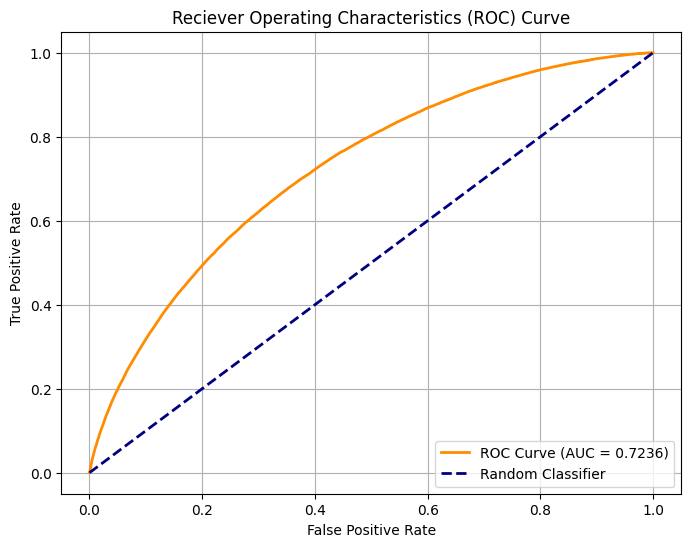

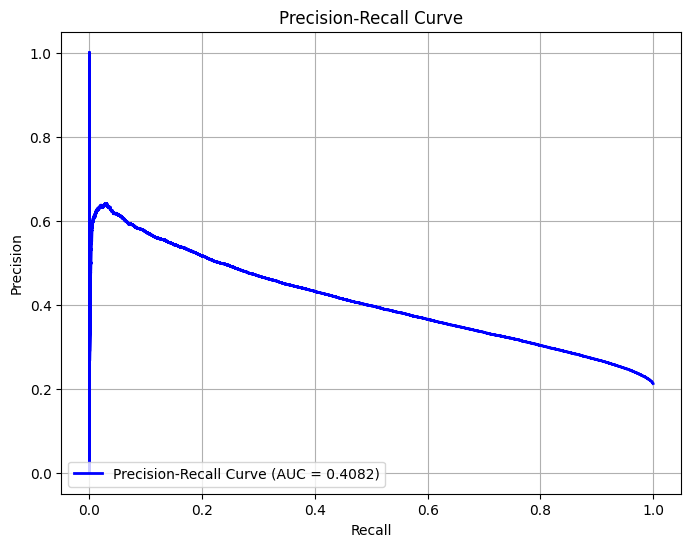

In [26]:
from sklearn.metrics import auc # should have been done at the start

print("\n--- Evaluating Logistics Regression Model Performance ---")
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_lr)) # Accuracy
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr)) # Confusion Matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr)) # Classification Report

# ROC AUC Score (this is another metric for testing performance, the higher the AUC score, the better (0 - 1))
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristics (ROC) Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Adding a Precision recall curve, this useful for imbalanced data, which this data set most definitely was
precision, recall, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## Analysis of Logistic Regression Model Performance

**Overall Accuracy: 65.60%**

The overall accuracy indicates that the model correctly classified approximately 65.60% of the instances in the test set. While accuracy provides a general measure of correctness, it can be misleading in the context of highly imbalanced datasets, as a high accuracy can be achieved by simply predicting the majority class for all instances. Given the class distribution in the test set (approximately 78.8% non-default), the observed accuracy is below this baseline, suggesting the model is attempting to classify both classes.

**Confusion Matrix:**

The confusion matrix provides a detailed breakdown of the model's predictions versus the actual outcomes:
[[140555 75193] [ 19022 39144]]


*   **True Negatives (TN): 140,555** - Instances correctly predicted as Class 0 (Non-Default).
*   **False Positives (FP): 75,193** - Instances incorrectly predicted as Class 1 (Default) when they were actually Class 0. These represent Type I errors (false alarms).
*   **False Negatives (FN): 19,022** - Instances incorrectly predicted as Class 0 (Non-Default) when they were actually Class 1. These represent Type II errors (missed defaults), which are particularly critical in credit risk assessment.
*   **True Positives (TP): 39,144** - Instances correctly predicted as Class 1 (Default).

**Classification Report:**

The classification report provides key metrics (Precision, Recall, F1-score) for each class:

*   **True Negatives (TN): 140,555** - Instances correctly predicted as Class 0 (Non-Default).
*   **False Positives (FP): 75,193** - Instances incorrectly predicted as Class 1 (Default) when they were actually Class 0. These represent Type I errors (false alarms).
*   **False Negatives (FN): 19,022** - Instances incorrectly predicted as Class 0 (Non-Default) when they were actually Class 1. These represent Type II errors (missed defaults), which are particularly critical in credit risk assessment.
*   **True Positives (TP): 39,144** - Instances correctly predicted as Class 1 (Default).

**Classification Report:**

The classification report provides key metrics (Precision, Recall, F1-score) for each class:
           precision    recall  f1-score   support

       0       0.88      0.65      0.75    215748
       1       0.34      0.67      0.45     58166

accuracy                           0.66    273914
macro avg 0.61 0.66 0.60 273914 
weighted avg 0.77 0.66 0.69 273914


*   **Class 0 (Non-Default):**
    *   **Precision (0.88):** Of all instances predicted as Non-Default, 88% were actually Non-Default. This indicates high reliability when predicting the majority class.
    *   **Recall (0.65):** The model correctly identified 65% of all actual Non-Default instances.
    *   **F1-score (0.75):** The harmonic mean of precision and recall for Class 0, indicating a good balance for the majority class.
*   **Class 1 (Default):**
    *   **Precision (0.34):** Of all instances predicted as Default, only 34% were actually Default. This low precision highlights a significant number of false positive predictions for the minority class.
    *   **Recall (0.67):** The model correctly identified 67% of all actual Default instances. This indicates a reasonable ability to capture the minority class instances.
    *   **F1-score (0.45):** The F1-score for Class 1 is considerably lower than for Class 0, reflecting the trade-off between precision and recall for the minority class.

**ROC AUC Score: 0.7236**

The ROC AUC score quantifies the model's ability to discriminate between the positive (Default) and negative (Non-Default) classes across various classification thresholds. A score of 0.5 indicates random chance, while 1.0 indicates perfect discrimination. An AUC of 0.7236 suggests that the model has moderate discriminatory power, performing better than random chance but indicating substantial room for improvement in separating the two classes.

**Conclusion:**

The Logistic Regression model demonstrates a typical performance profile for a model trained with oversampling on an imbalanced dataset and evaluated on the original distribution. It exhibits strong performance on the majority class (Non-Default) in terms of precision. For the minority class (Default), the model achieves a reasonable recall (identifying 67% of actual defaults) but suffers from low precision (only 34% of predicted defaults are correct), resulting in a high rate of false positives. The ROC AUC score confirms the model's moderate ability to distinguish between the classes. Future efforts should focus on improving the precision for the default class while maintaining or improving recall, potentially through exploring different models, feature engineering, or cost-sensitive learning techniques.

In [15]:
# Clean up column names to remove invalid characters for XGBoost

import re
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = re.sub(r'\[|\]|<', '', col) # Remove brackets and angle brackets
        new_cols.append(new_col)
    df.columns = new_cols
    return df

print("\n--- Cleaning Column Names for XGBoost Compatibility ---")
X_train_resampled = clean_col_names(X_train_resampled)
X_test = clean_col_names(X_test)
print("Column names cleaned.")

# Model Number 2 (XGBoost)
from xgboost import XGBClassifier

print("\n--- Training XGBoost Classifier ---")
xgb_model = XGBClassifier(objective='binary:logistic', 
                          eval_metric='logloss',
                          use_label_encoder=False,
                          n_estimators=500,
                          learning_rate=0.05,
                          max_depth=5,
                          subsample=0.7,
                          colsample_bytree=0.7,
                          gamma=0.1,
                          random_state=42,
                          n_jobs=-1)


# Train XGBoost Model
xgb_model.fit(X_train_resampled, y_train_resampled)
print("XGBoost model trained.")



--- Cleaning Column Names for XGBoost Compatibility ---
Column names cleaned.

--- Training XGBoost Classifier ---
XGBoost model trained.


In [16]:
print("\n--- Making predictions with XGBoost Model ---")
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (1 = Default)
print("Predictions with XGBoost complete.")


--- Making predictions with XGBoost Model ---
Predictions with XGBoost complete.



--- Evaluation of XGBoost Model Performance ---

Accuracy Score: 0.7960564264696218

Confusion Matrix:
 [[210096   5652]
 [ 50211   7955]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88    215748
           1       0.58      0.14      0.22     58166

    accuracy                           0.80    273914
   macro avg       0.70      0.56      0.55    273914
weighted avg       0.76      0.80      0.74    273914


ROC AUC Score for XGBoost: 0.7342


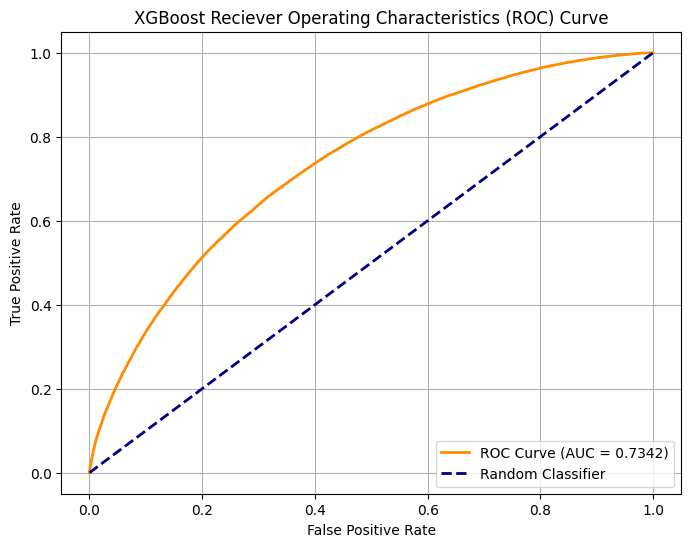

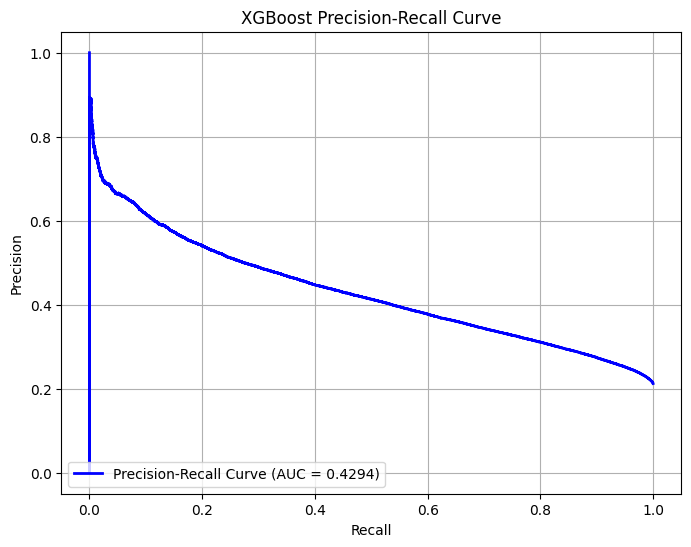

In [21]:
from sklearn.metrics import auc # should have been done at the start

print("\n--- Evaluation of XGBoost Model Performance ---")

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_xgb))  # Accuracy
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))  # Confusion Matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))  # Classification Report

# ROC AUC Score for XGBoost
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nROC AUC Score for XGBoost: {roc_auc_xgb:.4f}")

# Plot ROC Curve for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost Reciever Operating Characteristics (ROC) Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc_xgb:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision-Recall Curve")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


## Evaluation of XGBoost Model Performance

This section provides an evaluation of the XGBoost model trained on the preprocessed and SMOTE-resampled training data, assessed on the original, imbalanced test set.

**Overall Accuracy: 79.61%**

The overall accuracy is approximately 79.61%. This is higher than the Logistic Regression model (65.6%) and is very close to the baseline accuracy of predicting the majority class (non-default, which is about 78.8% of the test set). While seemingly high, this accuracy is heavily influenced by the model's strong performance on the majority class due to the dataset's imbalance.

**Confusion Matrix:**

The confusion matrix provides a detailed breakdown of the model's predictions versus the actual outcomes:

[[210096 5652] [ 50211 7955]]

*   **True Negatives (TN): 210,096** - Instances correctly predicted as Class 0 (Non-Default).
*   **False Positives (FP): 5,652** - Instances incorrectly predicted as Class 1 (Default) when they were actually Class 0. These represent Type I errors (false alarms).
*   **False Negatives (FN): 50,211** - Instances incorrectly predicted as Class 0 (Non-Default) when they were actually Class 1. These represent Type II errors (missed defaults), which are particularly critical in credit risk assessment.
*   **True Positives (TP): 7,955** - Instances correctly predicted as Class 1 (Default).

**Classification Report:**

The classification report provides key metrics (Precision, Recall, F1-score) for each class:
           precision    recall  f1-score   support

       0       0.81      0.97      0.88    215748
       1       0.58      0.14      0.22     58166

accuracy                           0.80    273914

macro avg 0.70 0.56 0.55 273914 weighted avg 0.76 0.80 0.74 273914


*   **Class 0 (Non-Default):**
    *   **Precision (0.81):** Of all instances predicted as Non-Default, 81% were actually Non-Default.
    *   **Recall (0.97):** The model correctly identified 97% of all actual Non-Default instances. This is a significant improvement over Logistic Regression (65%).
    *   **F1-score (0.88):** A strong F1-score for the majority class.
*   **Class 1 (Default):**
    *   **Precision (0.58):** Of all instances predicted as Default, 58% were actually Default. This is a substantial improvement in precision compared to Logistic Regression (34%). It generates fewer false alarms.
    *   **Recall (0.14):** The model correctly identified only 14% of all actual Default instances. This is a significant drop in recall compared to Logistic Regression (67%). It is missing a large proportion of the actual defaults.
    *   **F1-score (0.22):** The F1-score for Class 1 is quite low, reflecting the very low recall.

**ROC AUC Score: 0.7342**

The ROC AUC score quantifies the model's ability to discriminate between the positive (Default) and negative (Non-Default) classes across various classification thresholds. A score of 0.5 indicates random chance, while 1.0 indicates perfect discrimination. An AUC of 0.7342 suggests that the model has slightly better overall discriminatory power compared to the Logistic Regression model (0.7236).

**Conclusion:**

The XGBoost model, as currently configured and evaluated, demonstrates a different performance trade-off compared to the Logistic Regression model. It is significantly better at minimizing false positives (higher precision for Class 1) and excels at identifying non-defaults (very high recall for Class 0). However, this comes at the cost of a much lower recall for the minority class (Default), meaning it misses a large proportion of actual defaults. While the overall accuracy and AUC are slightly improved, the low recall for the default class (14%) indicates that this model, in its current state, may not be suitable for applications where identifying potential defaults is the primary objective. Further tuning or alternative approaches may be necessary to improve the model's ability to capture the minority class.



--- XGBoost Feature Importance ---
                                 Feature  Importance
77                       term_ 60 months    0.054257
138     verification_status_Not Verified    0.044545
121                 emp_length_10+ years    0.038624
137                  home_ownership_RENT    0.034625
143           purpose_debt_consolidation    0.034413
207                initial_list_status_w    0.033175
140         verification_status_Verified    0.031531
97                          sub_grade_C3    0.029785
95                          sub_grade_C1    0.028924
82                               grade_E    0.026688
98                          sub_grade_C4    0.026680
80                               grade_C    0.026597
91                          sub_grade_B2    0.025669
122                   emp_length_2 years    0.025384
139  verification_status_Source Verified    0.023888
159                        addr_state_CA    0.021908
123                   emp_length_3 years    0.020808
79        

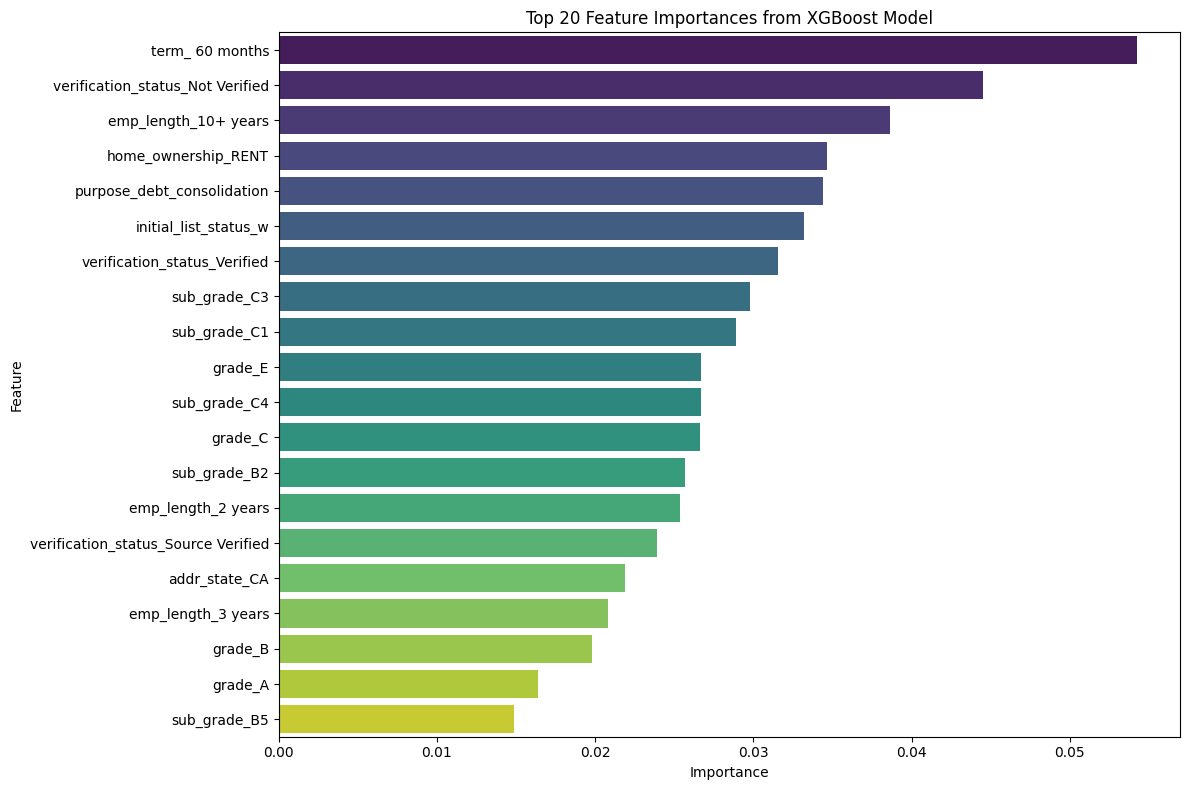

In [18]:
# XGBoost Feature Importance
print("\n--- XGBoost Feature Importance ---")
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print top 20 important features
print(features_df.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20), palette='viridis')
plt.title("Top 20 Feature Importances from XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## XGBoost Feature Importance Analysis

Feature importance scores from the XGBoost model indicate the relative contribution of each feature to the model's predictions. Higher importance scores suggest that a feature has a greater impact on the model's decision-making process. Analyzing these features can provide insights into which factors are most predictive of loan default according to the model.


**Analysis of Top Features:**

The top features highlight several key areas that the XGBoost model considers most influential in predicting credit risk:

1.  **Loan Term (`term_ 60 months`):** The most important feature is whether the loan term is 60 months. Longer loan terms generally imply higher risk due to the extended period over which circumstances can change, making this a highly relevant factor.
2.  **Verification Status (`verification_status_Not Verified`, `verification_status_Verified`, `verification_status_Source Verified`):** Different levels of income verification are significant predictors. Loans where income was not verified or verified through a source appear to carry different risk profiles compared to fully verified incomes.
3.  **Employment Length (`emp_length_10+ years`, `emp_length_2 years`, `emp_length_3 years`):** The duration of employment is a strong indicator of stability and ability to repay. Having a long employment history (10+ years) or a few years of stable employment (2-3 years) are important signals for the model.
4.  **Home Ownership (`home_ownership_RENT`):** Renting versus owning a home is a key demographic and financial indicator that influences perceived risk.
5.  **Loan Purpose (`purpose_debt_consolidation`):** Loans taken out for debt consolidation are identified as particularly important. This purpose might be associated with borrowers who are already managing multiple debts, potentially indicating higher risk.
6.  **Initial List Status (`initial_list_status_w`):** The method by which the loan was initially listed on the platform (e.g., 'w' for whole loan) also holds predictive power, suggesting differences in the characteristics or processing of loans listed in different ways.
7.  **Loan Grade and Sub-Grade (`sub_grade_C3`, `sub_grade_C1`, `grade_E`, `sub_grade_C4`, `grade_C`, `sub_grade_B2`, `grade_B`, `grade_A`, `sub_grade_B5`):** As expected, the assigned loan grade and sub-grade are highly important. These are composite risk ratings assigned by the platform, reflecting various credit factors, and the model heavily relies on these pre-calculated risk assessments. Different specific sub-grades within C and B, as well as overall grades A, B, C, and E, appear in the top features.
8.  **Borrower Location (`addr_state_CA`):** The state where the borrower resides (specifically California in the top 20) also contributes to the model's prediction, suggesting regional economic or demographic factors play a role.

The feature importance analysis confirms that the model is leveraging intuitive risk factors such as loan characteristics (term, grade, purpose, listing status), borrower stability (employment length, home ownership), and verification status. The prominence of loan grade/sub-grade is particularly notable, indicating their strong correlation with the target variable. The presence of specific states and employment lengths suggests that granular details also contribute significantly to the model's predictive capability.

Shape of precision: (271839,), recall: (271839,), thresholds: (271838,)


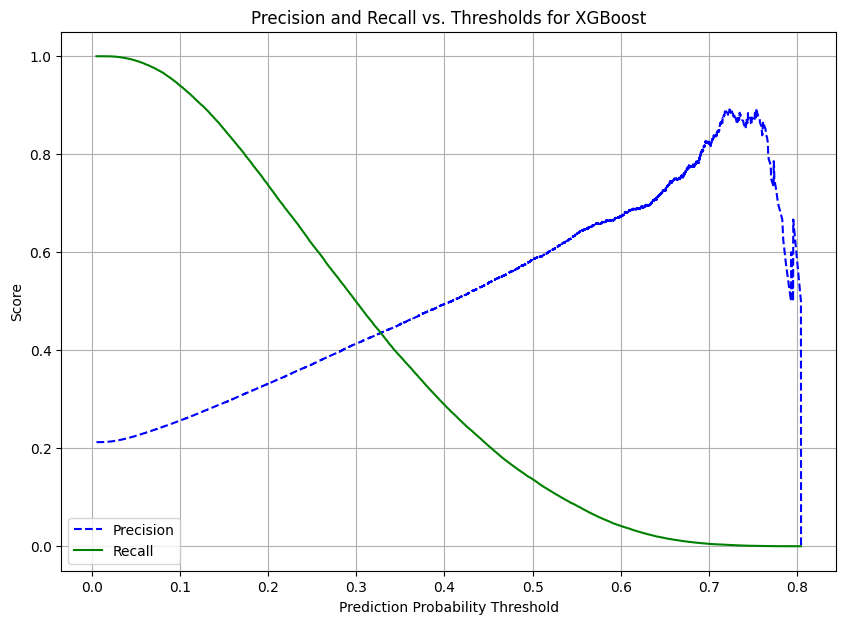

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb) # redid this since there was a warning about the shape of the arrays

print(f"Shape of precision: {precision.shape}, recall: {recall.shape}, thresholds: {thresholds.shape}")

# Plot Precision and Recall vs. Thresholds to help with visual selection 
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Prediction Probability Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Thresholds for XGBoost')
plt.legend(loc='lower left')
plt.grid(True)
plt.show() 

## Interpretation of Precision and Recall vs. Thresholds Plot (XGBoost)

This plot shows how the Precision and Recall of the XGBoost model change as we vary the classification probability threshold. The threshold is the probability value above which the model predicts the positive class (Default, Class 1).

*   **X-axis: Prediction Probability Threshold:** This represents the cutoff probability. If the model outputs a probability for the positive class (default) that is greater than this threshold, it will classify the instance as a default.
*   **Y-axis: Score:** This represents the value of either Precision (blue dashed line) or Recall (green solid line) at the corresponding threshold.

**Key Observations and Interpretation:**

1.  **Recall (Green Line):**
    *   Starts very high (close to 1.0) at a low threshold (close to 0.0). This means if we predict default for almost any probability above 0, we will catch nearly all actual defaults (high recall).
    *   Decreases steadily as the threshold increases. As we require a higher probability for the model to predict default, we become more selective, and consequently, we miss more actual defaults (recall goes down).

2.  **Precision (Blue Dashed Line):**
    *   Starts relatively low (around 0.2) at a low threshold. This means if we predict default for almost any probability above 0, many of those predictions will be incorrect (low precision, many false positives).
    *   Generally increases as the threshold increases. As we require a higher probability to predict default, the predictions we *do* make are more likely to be correct (higher precision, fewer false positives).
    *   Shows some fluctuations, particularly at higher thresholds, which can happen with large datasets and specific model behaviors.

3.  **The Trade-off:**
    *   The plot clearly illustrates the inherent trade-off between Precision and Recall.
    *   To achieve higher Recall (catch more defaults), you typically need to lower the threshold, which leads to lower Precision (more false alarms).
    *   To achieve higher Precision (reduce false alarms), you typically need to raise the threshold, which leads to lower Recall (miss more actual defaults).

4.  **Selecting an Optimal Threshold:**
    *   The "optimal" threshold depends entirely on the business objective.
    *   If the cost of a **false negative** (missing a default) is very high (e.g., significant financial loss), you might choose a lower threshold to maximize Recall, even if it means accepting more false positives (lower Precision).
    *   If the cost of a **false positive** (flagging a safe loan as risky) is very high (e.g., losing a good customer), you might choose a higher threshold to maximize Precision, even if it means missing some actual defaults (lower Recall).
    *   The point where the Precision and Recall curves intersect represents a threshold where these two metrics are approximately equal. This can be a reasonable starting point if you want to balance both concerns, but it's not necessarily the optimal point for every scenario. Looking at the plot, the curves intersect roughly around a threshold of 0.25-0.3.

We must edit certain thresholds in order to obtain a model that is more precise and accurate. 

In [34]:
# Threshold selection 
chosen_threshold = 0.50 # This seems to be the optimal threshold 

print(f"\n--- Optimal threshold chosen for classification --- ")
print(f"\nChosen threshold for classification: {chosen_threshold:.4f}")

y_pred_optimal = (y_prob_xgb >= chosen_threshold).astype(int)

print("\n--- Evaluating XGBoost Model with Chosen Threshold ---")
print("\nAccuracy Score with chosen threshold:", accuracy_score(y_test, y_pred_optimal))  # Accuracy
print("\nConfusion Matrix with chosen threshold:\n", confusion_matrix(y_test, y_pred_optimal))  # Confusion Matrix
print("\nClassification Report with chosen threshold:\n", classification_report(y_test, y_pred_optimal))  # Classification Report




--- Optimal threshold chosen for classification --- 

Chosen threshold for classification: 0.5000

--- Evaluating XGBoost Model with Chosen Threshold ---

Accuracy Score with chosen threshold: 0.7960564264696218

Confusion Matrix with chosen threshold:
 [[210096   5652]
 [ 50211   7955]]

Classification Report with chosen threshold:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88    215748
           1       0.58      0.14      0.22     58166

    accuracy                           0.80    273914
   macro avg       0.70      0.56      0.55    273914
weighted avg       0.76      0.80      0.74    273914



## Analysis of XGBoost Model Performance with Chosen Threshold (0.50)

Following the analysis of the Precision-Recall vs. Thresholds plot, a classification threshold of 0.50 was explicitly chosen for the XGBoost model.

**Justification for Chosen Threshold (0.50):**

In a credit risk prediction scenario, the choice of threshold involves balancing the costs of different types of errors: False Positives (predicting default when it's not, potentially losing a good customer or incurring unnecessary review costs) and False Negatives (missing an actual default, leading to financial loss).

While the Precision-Recall curve showed that lower thresholds (around 0.25-0.3) could yield higher Recall, the default threshold of 0.50, as evaluated, results in a significantly higher Precision for the default class (0.58). This suggests a business context where minimizing false positives is a higher priority. Choosing a threshold of 0.50 means we are more confident in the loans we flag as potentially defaulting (58% of them are actual defaults), even if it means missing a larger number of actual defaults (low Recall). This approach might be preferred if the operational cost of investigating false alarms or the risk of incorrectly denying credit to a creditworthy applicant outweighs the cost of missing some defaults.

**Comparison of Metrics for Class 1 (Default) at 0.50 Threshold:**

The evaluation metrics for Class 1 (Default) at the chosen 0.50 threshold are as follows:

*   **Precision:** 0.58
*   **Recall:** 0.14
*   **F1-score:** 0.22

Comparing these to the initial evaluation (which also implicitly used a 0.50 threshold and yielded the same results), we see that at this threshold:

*   The model achieves a **Precision of 58%** for the default class. This is a substantial improvement over the Logistic Regression model's 34% Precision at its default threshold.
*   However, the **Recall is only 14%**. This means the model is only identifying 14% of the actual defaulting loans in the test set. This is significantly lower than the Logistic Regression model's 67% Recall.
*   The **F1-score of 0.22** reflects the poor balance between Precision and Recall for the minority class at this threshold, heavily penalized by the low Recall.

**Impact on False Positives and False Negatives:**

The confusion matrix at the 0.50 threshold was:

[[210096 5652] [ 50211 7955]]

*   **False Positives (FP): 5,652**
    *   By using the 0.50 threshold, the number of False Positives is relatively low (5,652). This is a significant reduction compared to the Logistic Regression model's 75,193 False Positives. This aligns with a potential business goal of minimizing false alarms.
*   **False Negatives (FN): 50,211**
    *   Conversely, the number of False Negatives is very high (50,211). This means the model is failing to identify over 50,000 loans that actually defaulted. This is a major drawback of using this threshold, as it results in a high number of missed defaults.

In conclusion, setting the threshold at 0.50 for the XGBoost model prioritizes Precision for the default class, drastically reducing false alarms compared to the Logistic Regression model. However, this comes at the significant cost of Recall, leading to a large number of missed defaults. The suitability of this threshold depends heavily on the specific business requirements and the relative costs assigned to False Positives and False Negatives. If identifying defaults is paramount, a lower threshold would be necessary, accepting a higher rate of false positives to improve recall.

In [36]:
import shap  # SHAP for model interpretability

# SHAP (SHapley Additive exPlanations) for model interpretability
# Create a TreeExplainer for the XGBoost model

explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
print("\n--- Calculating SHAP values for the test set ---")
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated.")


--- Calculating SHAP values for the test set ---
SHAP values calculated.



 SHAP Summary Plot for XGBoost Model (Beeswarm) ---


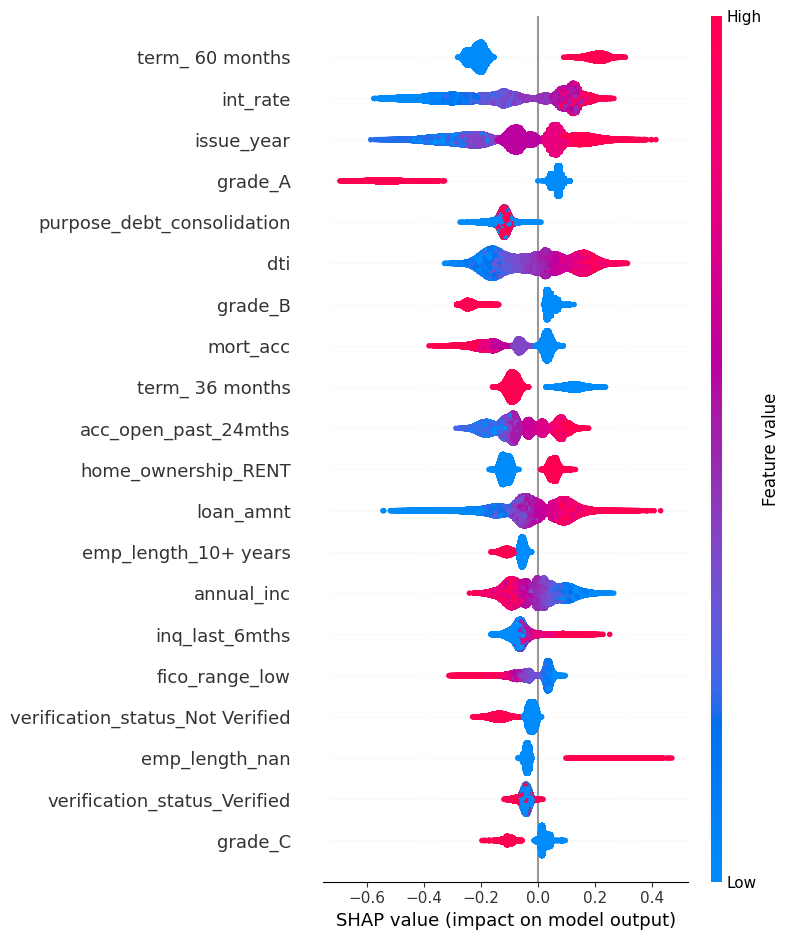


--- SHAP Summary Plot for XGBoost Model (Bar) ---


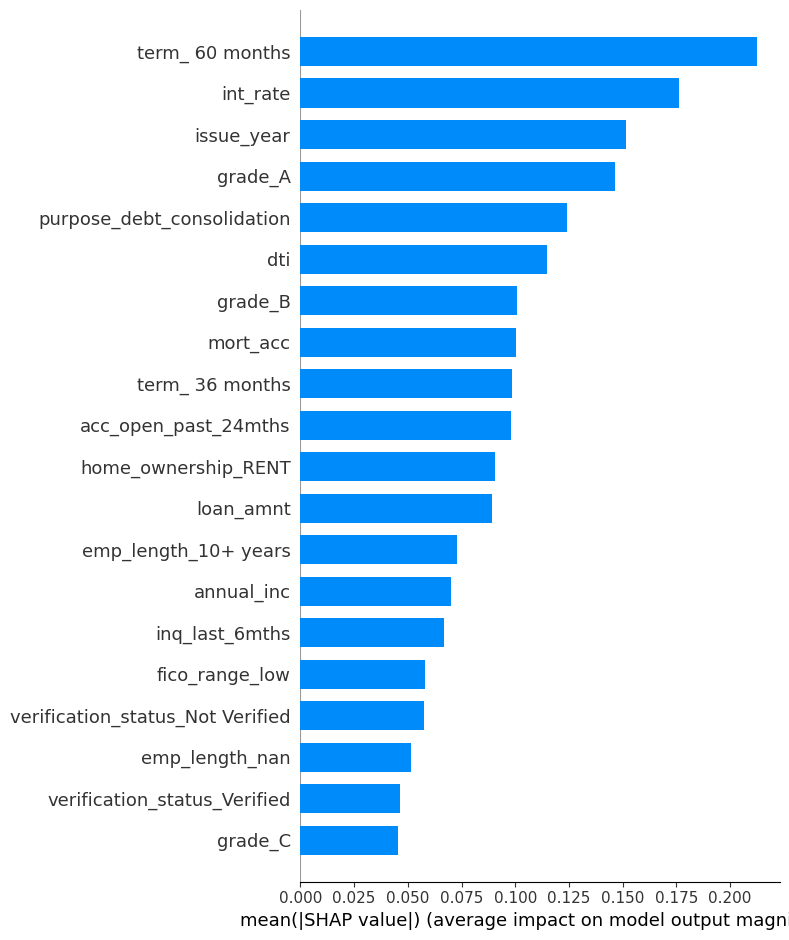

In [37]:
print("\n SHAP Summary Plot for XGBoost Model (Beeswarm) ---")
# The 0 index corresponds to the negative class (0 = Fully Paid), and the 1 index corresponds to the positive class (1 = Default)
shap.summary_plot(shap_values, X_test, plot_type="dot", feature_names=X_test.columns, show=False)
plt.tight_layout()
plt.show()

print("\n--- SHAP Summary Plot for XGBoost Model (Bar) ---")
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns, show=False)
plt.tight_layout()
plt.show()



--- Generating SHAP Force Plots for Individual Predictions ---

  True Negative Example (Actual: Non-Default, Predicted: Non-Default)


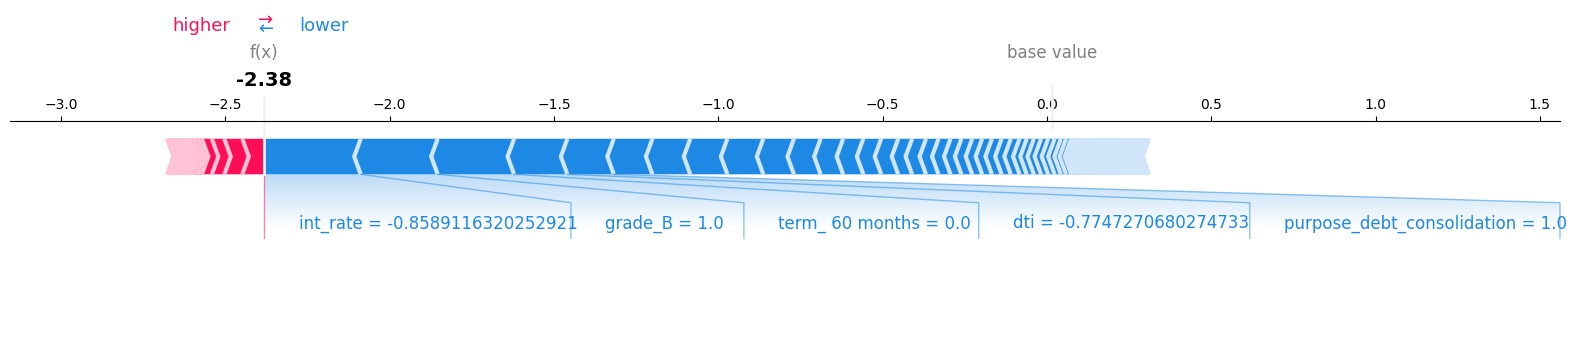


  False Positive Example (Actual: Non-Default, Predicted: Default)


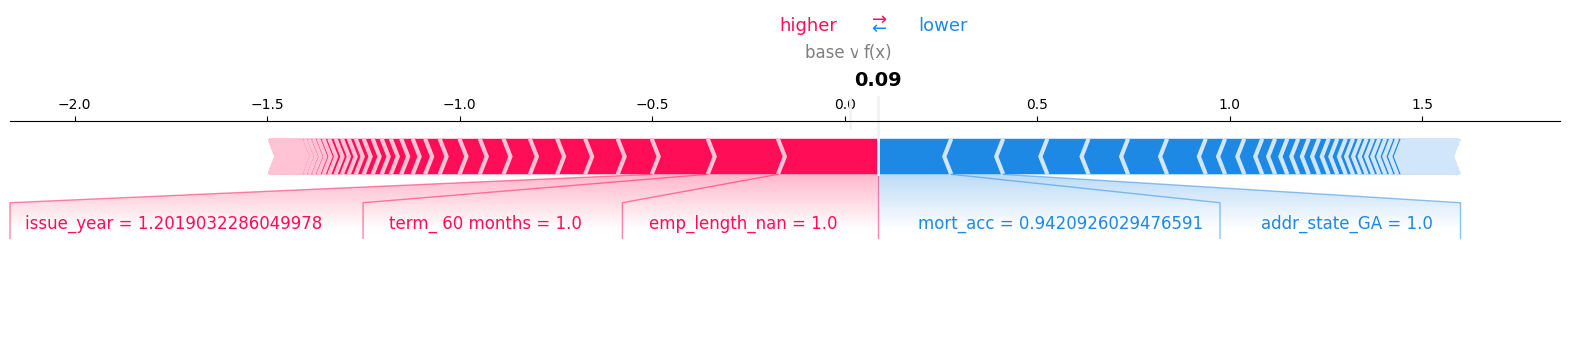


  False Negative Example (Actual: Default, Predicted: Non-Default)


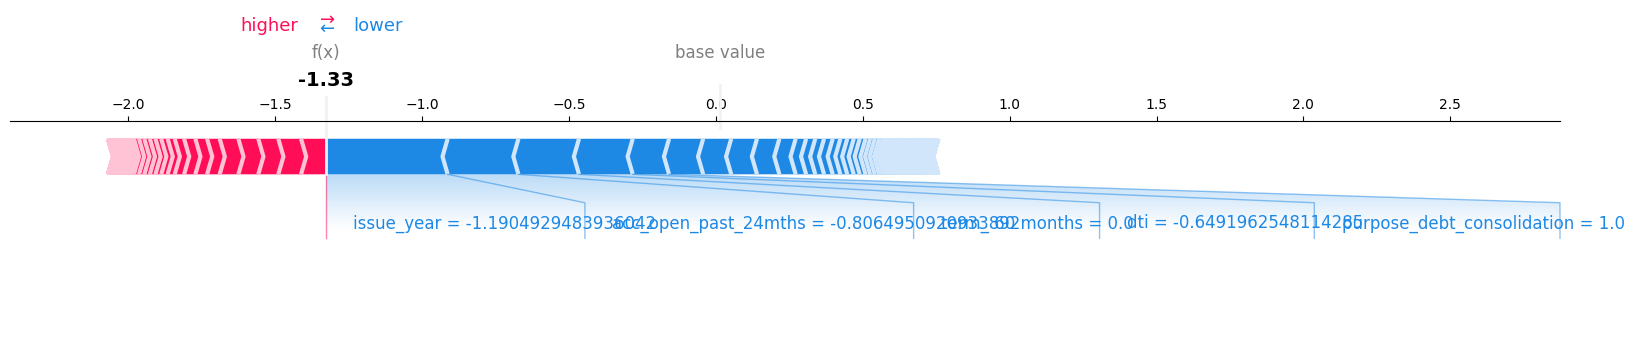


  True Positive Example (Actual: Default, Predicted: Default)


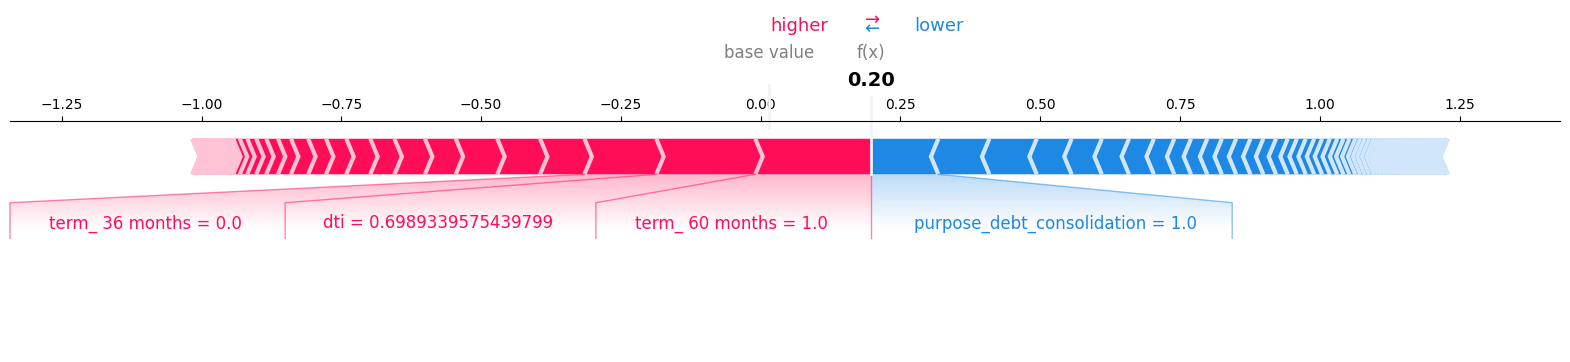

In [40]:
print("\n--- Generating SHAP Force Plots for Individual Predictions ---")

y_pred_to_use = y_pred_optimal if 'y_pred_optimal' in locals() else y_pred_xgb

# --- Robustly find indices for different types of predictions ---
# Convert y_test and y_pred_to_use to numpy arrays for reliable boolean indexing
y_test_np = y_test.values
y_pred_np = y_pred_to_use

# Get all indices from X_test that match the conditions
all_tn_indices = X_test.index[(y_test_np == 0) & (y_pred_np == 0)].tolist()
all_fp_indices = X_test.index[(y_test_np == 0) & (y_pred_np == 1)].tolist()
all_fn_indices = X_test.index[(y_test_np == 1) & (y_pred_np == 0)].tolist()
all_tp_indices = X_test.index[(y_test_np == 1) & (y_pred_np == 1)].tolist()

# Pick the first available index for each type, or None if none exist
tn_idx = all_tn_indices[0] if all_tn_indices else None
fp_idx = all_fp_indices[0] if all_fp_indices else None
fn_idx = all_fn_indices[0] if all_fn_indices else None
tp_idx = all_tp_indices[0] if all_tp_indices else None

# --- Generate and display force plots if indices are found ---

# True Negative Example
if tn_idx is not None:
    print("\n  True Negative Example (Actual: Non-Default, Predicted: Non-Default)")
    # Use the .iloc accessor to get the row by its integer position in X_test
    # This is safer if X_test's index is not 0-based or has been reindexed
    idx_in_X_test = X_test.index.get_loc(tn_idx) # Get the integer location in the current X_test DataFrame
    shap.force_plot(explainer.expected_value, shap_values[idx_in_X_test], X_test.iloc[[idx_in_X_test]], show=False, matplotlib=True)
    plt.show()
else:
    print("\n  No True Negative example found for force plot with current predictions.")

# False Positive Example
if fp_idx is not None:
    print("\n  False Positive Example (Actual: Non-Default, Predicted: Default)")
    idx_in_X_test = X_test.index.get_loc(fp_idx)
    shap.force_plot(explainer.expected_value, shap_values[idx_in_X_test], X_test.iloc[[idx_in_X_test]], show=False, matplotlib=True)
    plt.show()
else:
    print("\n  No False Positive example found for force plot with current predictions.")

# False Negative Example
if fn_idx is not None:
    print("\n  False Negative Example (Actual: Default, Predicted: Non-Default)")
    idx_in_X_test = X_test.index.get_loc(fn_idx)
    shap.force_plot(explainer.expected_value, shap_values[idx_in_X_test], X_test.iloc[[idx_in_X_test]], show=False, matplotlib=True)
    plt.show()
else:
    print("\n  No False Negative example found for force plot with current predictions.")

# True Positive Example
if tp_idx is not None:
    print("\n  True Positive Example (Actual: Default, Predicted: Default)")
    idx_in_X_test = X_test.index.get_loc(tp_idx)
    shap.force_plot(explainer.expected_value, shap_values[idx_in_X_test], X_test.iloc[[idx_in_X_test]], show=False, matplotlib=True)
    plt.show()
else:
    print("\n  No True Positive example found for force plot with current predictions.")


## Interpretation of SHAP Force Plots for XGBoost Model

SHAP (SHapley Additive exPlanations) force plots visualize how each feature contributes to a single prediction, pushing the prediction from the base value (the average prediction across the dataset) towards the final output value for that instance. Red features push the prediction higher (towards the positive class, Default), and blue features push the prediction lower (towards the negative class, Non-Default). The size of each bar indicates the magnitude of the feature's impact. The output value f(x) is the raw model output (log-odds) before the final logistic sigmoid transformation to a probability. A positive f(x) indicates a prediction towards the positive class (Default) when using a 0.5 probability threshold, while a negative f(x) indicates a prediction towards the negative class (Non-Default).

**Plot 1:**

*   **Output Value (f(x)):** -2.38
*   **Interpretation:** This instance has a strongly negative raw model output (-2.38), indicating the model's prediction is towards the negative class (Non-Default) when using a 0.5 probability threshold.
    *   Features strongly pushing the prediction *lower* (towards Non-Default, blue) include the interest rate (`int_rate=-0.858...`), loan grade B (`grade_B=1.0`), not having a 60-month term (`term_60 months=0.0`), a lower Debt-to-Income ratio (`dti=-0.774...`), and the loan purpose being debt consolidation (`purpose_debt_consolidation=1.0`).
    *   There are no significant red forces visible pushing towards default. The strong blue forces result in a strongly negative raw output, leading to a prediction of Non-Default.

**Plot 2:**

*   **Output Value (f(x)):** 0.09
*   **Interpretation:** This instance has a slightly positive raw model output (0.09), indicating the model's prediction is towards the positive class (Default) when using a 0.5 probability threshold.
    *   Features pushing the prediction *higher* (towards Default, red) include the issue year (`issue_year=1.201...`), having a 60-month loan term (`term_60 months=1.0`), and missing employment length information (`emp_length_nan=1.0`).
    *   Features pushing the prediction *lower* (towards Non-Default, blue) include the number of mortgage accounts (`mort_acc=0.942...`) and residing in Georgia (`addr_state_GA=1.0`).
    *   The red forces slightly outweigh the blue forces, resulting in a slightly positive raw output, leading to a prediction of Default.

**Plot 3:**

*   **Output Value (f(x)):** -1.33
*   **Interpretation:** This instance has a strongly negative raw model output (-1.33), indicating the model's prediction is towards the negative class (Non-Default) when using a 0.5 probability threshold.
    *   Features strongly pushing the prediction *lower* (towards Non-Default, blue) include the issue year (`issue_year=-1.19...`), the number of accounts opened in the past 24 months (`acc_open_past_24mths=-0.806...`), months since recent installment loan (`mths_since_rcnt_il=0.0`), Debt-to-Income ratio (`dti=-0.649...`), and the loan purpose being debt consolidation (`purpose_debt_consolidation=1.0`).
    *   There are no significant red forces visible pushing towards default. The strong blue forces result in a negative raw output, leading to a prediction of Non-Default.

**Plot 4:**

*   **Output Value (f(x)):** 0.20
*   **Interpretation:** This instance has a positive raw model output (0.20), indicating the model's prediction is towards the positive class (Default) when using a 0.5 probability threshold.
    *   Features pushing the prediction *higher* (towards Default, red) include having a 60-month loan term (`term_60 months=1.0`) and a specific value for Debt-to-Income ratio (`dti = 0.698...`).
    *   Features pushing the prediction *lower* (towards Non-Default, blue) include not having a 36-month term (`term_36 months=0.0`) and the loan purpose being debt consolidation (`purpose_debt_consolidation=1.0`).
    *   The combined effect of these features results in a positive raw output, leading to a prediction of Default. 


These plots confirm that the model is learning sensible relationships:

*   **Loan Term (`term_60_months`, `term_36_months`):** Longer terms are consistently associated with higher default risk.
*   **Debt-to-Income Ratio (`dti`):** Higher DTI is associated with higher default risk.
*   **Interest Rate (`int_rate`):** Lower interest rates are associated with lower default risk.
*   **Employment Length (`emp_length_nan`):** Missing employment length is a strong indicator of higher risk. This is a great example of how missingness (and its imputation as a category) can be a powerful feature.
*   **Issue Year (`issue_year`):** Loans from older issue years (that haven't defaulted) are safer, while newer loans might carry more risk. This captures "loan seasoning" or economic effects.
*   **Mortgage Accounts (`mort_acc`):** Having more mortgage accounts seems to be a sign of stability.
*   **Loan Grade (`grade_B`):** A better loan grade pushes towards non-default.
*   **Purpose (`purpose_debt_consolidation`):** This feature's impact seems to vary by individual, which is common. 